### Model Interpretation

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('american_pit_bull_terrier', 'american_bulldog', 7),
 ('Bengal', 'Egyptian_Mau', 6),
 ('Egyptian_Mau', 'Bengal', 5)]

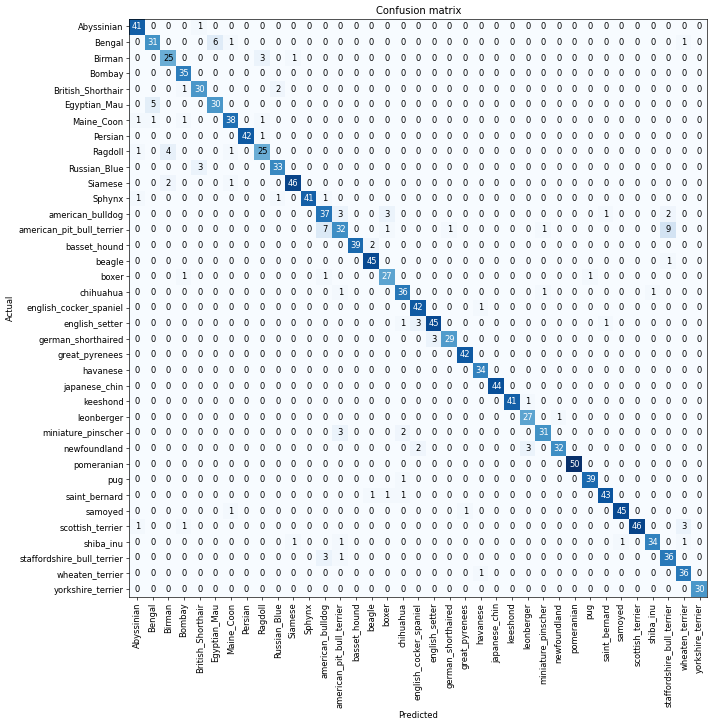

In [22]:
from fastai.vision.all import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)

# Confusion matrix (37*37)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# The most incorrect predictions (at least 5 incorrect preds)
interp.most_confused(min_val=5)

The Learning Rate Finder

In [23]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1) # head only - 1 epoch, total network - 1 epoch
# 0.1 learning rate --> too high: overshooting, error rate increased

epoch,train_loss,valid_loss,error_rate,time
0,2.773521,4.363466,0.478349,00:28


epoch,train_loss,valid_loss,error_rate,time
0,4.383031,3.504344,0.917456,00:30


minimum/10 → 1.20e-02,  steepest → 2.51e-03


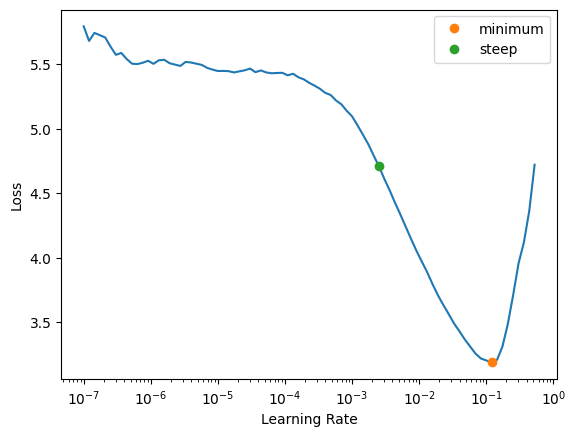

In [25]:
# To find a optimal lr
from fastai.callback.schedule import steep, minimum
learn = cnn_learner(dls, resnet34, error_rate)
# tell lr_find to return (minimum, steep) instead of just one of them
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

print(f"minimum/10 → {lr_min:.2e},  steepest → {lr_steep:.2e}")


## Choosing an Appropriate Learning Rate (≈3e-3)

- **Steepest Descent Region**  
  - Around **10⁻³**, the loss curve begins to drop most sharply.  
  - Selecting a learning rate here ensures we move quickly down the loss surface without wasted small steps.

- **Avoiding Overshoot**  
  - Going much higher (≳10⁻¹) causes the optimizer to jump past the minimum and the loss to rise.  
  - Staying below the “minimum/10” point (≈8×10⁻³) keeps training stable.

- **Balancing Speed and Stability**  
  - **3e-3** (i.e. 3×10⁻³ = 0.003) sits between the “steepest” point (~6×10⁻³) and the “minimum/10” point (~8×10⁻³).  
  - This conservative midpoint maximizes convergence speed while minimizing the risk of divergence.

> **Note:**  
> “3e-3” means **3 × 10⁻³**, or **0.003**.

### Unfreezing and Transfer Learning

### 1. Transfer Learning의 의미

#### 1.1 백본(Backbone)의 역할
- ImageNet 등 큰 데이터셋으로 사전학습된 CNN(예: ResNet)은  
  - **초반 레이어**: 엣지·모서리 같은 일반적인 특징  
  - **중간 레이어**: 형태·질감  
  - **후반 레이어**: 물체나 패턴의 고수준 표현  
- 이 “일반적인 시각 특징”을 **재사용**하려는 것이 **transfer learning**

#### 1.2 마지막 분류층(Head) 교체
- 원래 사전학습된 모델의 **마지막 FC 레이어**는 ImageNet의 1,000개 클래스를 분류하도록 설계됨  
- 우리 과제(예: 애완동물 품종 37개)에 맞추려면  
  1. 해당 레이어를 **버리고**  
  2. 원하는 클래스 수(37)만큼 출력 뉴런을 가지는 **새로운 FC 레이어**를 붙여야 함  
  3. 이 새 레이어는 **랜덤 가중치**로 초기화  

---

### 2. “Freeze” 단계

- **동기**  
  - 사전학습된 백본 가중치는 이미 일반적인 특징을 잘 잡아내도록 학습돼 있으므로,  
  - **처음부터 헤드만 학습**시켜 “내 태스크”에 빠르게 적응시키자

- **동작**  
  1. Optimizer에 **백본 파라미터**는 `requires_grad=False`로 설정  
  2. 오직 **추가한 FC 레이어(헤드)**만 `requires_grad=True`  
  3. `learn.fine_tune(...)` 호출 시 **첫 에폭(기본 1번)** 은 이 상태로 학습  

---

### 3. “Unfreeze” 단계

- **동기**  
  - 헤드가 내 데이터에 맞춰 어느 정도 잡히면,  
  - 백본도 **미세 조정**(fine-tune)하여 도메인에 더 특화된 표현을 학습하도록 하자

- **동작**  
  1. `learn.fine_tune` 내부에서 **첫 에폭 후**  
  2. **모든 레이어**(`requires_grad=True`)를 **언프리즈**(unfreeze)  
  3. **나머지 에폭 동안**(예: 추가 2번) **백본+헤드 전부** 학습  

In [28]:
learn=cnn_learner(dls, resnet34)
learn.freeze??

Signature: learn.freeze()
Docstring: Freeze up to last parameter group
Source:   
@patch
def freeze(self:Learner): self.freeze_to(-1)
File:      /usr/local/lib/python3.11/dist-packages/fastai/learner.py
Type:      method


In [32]:
learn = cnn_learner(dls, resnet34, error_rate) 
# requires_grad=False for the body, requires_grad=True for the head 
# FastAI automatically calls learn.freeze() to do this
learn.fit_one_cycle(3, 3e-3) # 3 epoch동안, head(새로 추가한 FC layer만) 학습
# lr = 0.003을 최대값으로 잡아 1cycle 적용 


epoch,train_loss,valid_loss,time
0,1.124454,0.298573,00:35
1,0.517858,0.244871,00:34
2,0.322853,0.219758,00:34


In [33]:
# unfreeze --> lr_find 
# 왜 다시 하나? --> 이제 backbone까지 학습대상, 랜덤으로 초기화된 head만 학습시 찾은 lr(3e-3)은 더이상 최적이 아님
learn.unfreeze()


SuggestedLRs(valley=7.585775892948732e-05)

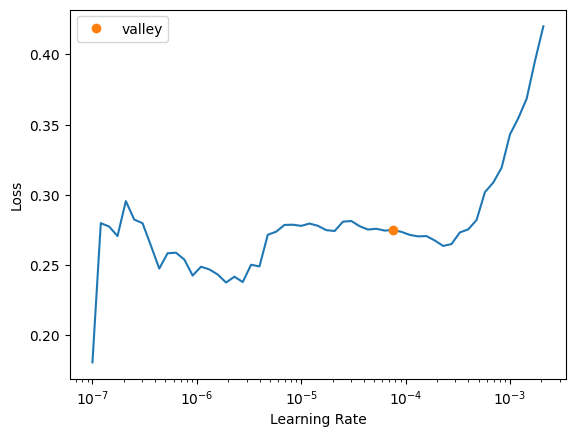

In [34]:
learn.lr_find()

In [35]:
learn.fit_one_cycle(6, lr_max=1e-5) # 6 epoch, 모든 레이어(unfreeze)를 학습 대상으로, 최대 lr=1e-5

epoch,train_loss,valid_loss,time
0,0.267145,0.212836,00:35
1,0.253683,0.209227,00:36
2,0.230484,0.202976,00:36
3,0.198976,0.195541,00:36
4,0.182334,0.196503,00:37
5,0.174632,0.194832,00:37


## `learn.freeze()` vs `learn.unfreeze()`

- **`learn.freeze()`**  
  - **백본(body)**: `requires_grad=False` → **동결(frozen)**  
  - **헤드(head)**: `requires_grad=True` → **학습 대상**

- **`learn.unfreeze()`**  
  - **모든 레이어**(`body` + `head`): `requires_grad=True` → **전체 네트워크 학습 대상**

### 사용 예시

```python
from fastai.vision.all import *

# 1) Learner 생성 (백본 자동 동결)
learn = cnn_learner(dls, resnet34, metrics=error_rate)

# 2) freeze 단계: 헤드만 학습
learn.freeze()
learn.fit_one_cycle(3, 3e-3)

# 3) unfreeze 단계: 전체 네트워크 학습
learn.unfreeze()
learn.fit_one_cycle(6, lr_max=1e-5)
```
- **`learn.fine_tune(epochs, base_lr)`**  
  빠르고 간단하게 **freeze → fit → unfreeze → fit**을 한 번에 실행해 주는 메서드
  ```python
  # 내부적으로 다음 두 단계를 한 줄로 처리
  learn.fine_tune(3, base_lr=3e-3)
  # 1) 헤드만 1 epoch 학습 (freeze + fit_one_cycle)
  # 2) 전체 네트워크 2 epoch 학습 (unfreeze + fit_one_cycle)

### Discriminative Learning Rates
- **문제의식**  
  - 사전학습된 백본은 **수백 에폭, 수백만 이미지**로 이미 학습된 가중치  
  - **가장 낮은 레이어**(엣지·모서리)   → 거의 모든 시각 태스크에 유용  
  - **가장 높은 레이어**(“눈”, “일몰” 등) → 도메인마다 유용도가 다름  
  - 따라서 **모든 레이어에 같은 학습률**을 쓰면 초반 레이어는 과도하게 바뀌고 최종 레이어는 학습이 느려질 수 있음

- **Core Idea** : **different layers of a neural network should train at different speeds!**
  1. **초반 레이어**에는 **낮은 학습률**  
  2. **후반 레이어**(특히 새로 추가한 헤드)에는 **높은 학습률**  
  3. 이렇게 하면 “일반적인 특징”은 천천히 보존하면서 “도메인 특화 표현”은 빠르게 학습 가능

- **FastAI 사용법**  
  ```python
  # Learner 생성 (기본적으로 freeze 상태)
  learn = cnn_learner(dls, resnet34, metrics=error_rate)
  learn.freeze()

  # discriminative LR: slice(초반_lr, 후반_lr)
  # 예: 1e-6 → 1e-4 구간에 걸쳐 학습률 차등 적용
  learn.fit_one_cycle(
      5,
      lr_max = slice(1e-6, 1e-4)
  )

In [39]:
# fastAI로 레이어별 lr 적용
# 1) Head 먼저 3 epoch 학습
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3) # 기본적으로 loss 줄어듦 

epoch,train_loss,valid_loss,error_rate,time
0,1.157085,0.326764,0.097429,00:37
1,0.547016,0.267996,0.085927,00:37
2,0.339741,0.238682,0.068336,00:37


In [40]:
# 2) 전체 네트워크 unfreeze + discriminative LR
learn.unfreeze()
learn.fit_one_cycle(12, lr_max = slice(1e-6, 1e-4)) 
# slice--> 초반 레이어 그룹 lr≈1×10⁻⁶ --> 후반 레이어그룹 (head) lr≈1×10⁻⁴
# 중간 layers -- 초반과 후반 레이어 사이를 interpolation 

epoch,train_loss,valid_loss,error_rate,time
0,0.273488,0.234094,0.071719,00:38
1,0.255742,0.217590,0.072395,00:38
2,0.242505,0.211491,0.071042,00:37
3,0.210038,0.206192,0.066982,00:37
4,0.187592,0.205400,0.071042,00:37
5,0.176389,0.202476,0.067659,00:36
6,0.155280,0.200416,0.068336,00:37
7,0.154584,0.207132,0.067659,00:37
8,0.133394,0.202485,0.066306,00:36
9,0.130107,0.199444,0.063599,00:36


Train loss keep decreases, whereas error rate increases past epoch=6  --> Signal of overfitting

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

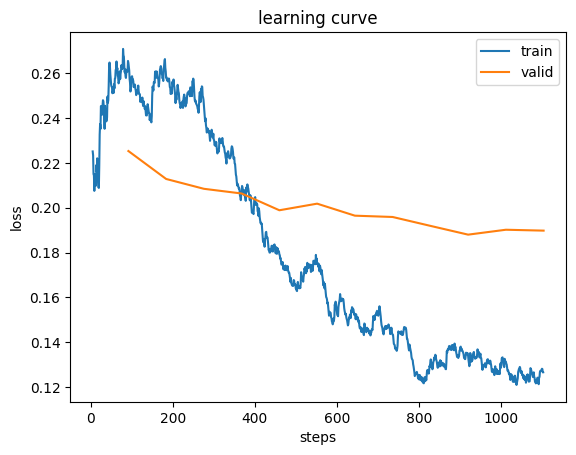

In [38]:
learn.recorder.plot_loss()

## 표와 그래프 요약

- **train_loss ↓, valid_loss plateau/↑** --> overfitting

- **error_rate**(또는 **accuracy**)만 보고 **학습 중단 시점** 판단  
  손실(loss) 대신 우리가 실제로 중요하게 생각하는 **정확도** 기준으로 멈추기

> **핵심**  
> 1. 학습 결과를 보면, **validation loss**가 올라가더라도 accuracy(또는 사용자가 정의한 메트릭)가 계속 개선될 수 있음  
> 2. 최종 평가는 **loss**가 아니라 **accuracy** 등 메트릭으로 해야 함.  
> 3. loss는 **단지 컴퓨터가 최적화할 수 있도록 제공한 도구**일 뿐임.

## Selecting the Number of Epochs

1. **시간 제한 고려**  
   - 일반화 성능보다 **실제 사용 가능한 학습 시간**이 우선임 
   - **허용 가능한 대기 시간** 안에 끝낼 수 있는 에폭 수를 먼저 정해야 함

2. **메트릭(정확도 등) 모니터링**  
   - 학습 후 **train/valid 손실 곡선**과 **선택한 메트릭**을 확인 
   - 마지막 epoch에서도 metric이 계속 개선된다면 **더 학습해야 했다**는 신호

3. **validation loss vs. overfitting 주의**  
   - validation loss --> over-confidence 단계에서 먼저 올라가고, 그 다음 “데이터 암기” 단계에서 추가로 악화 

4. **과거의 방식: Early Stopping**  
   - 각 에폭마다 모델을 저장한 뒤 **best metric**을 낸 체크포인트를 불러 사용  
   - 단점: 중간 에폭의 모델은 학습률 스케줄의 **최적 지점**을 놓칠 수 있음.

5. **권장 접근법**  
   - 과적합 징후가 보이면 **처음부터 재학습**하되,“최고 메트릭이 기록된 에폭 수”를 기준으로 **총 에폭 수**를 설정  
   - 시간 여유가 있다면 단순 에폭 증가보다 더 깊은 모델 아키텍처를 고려

> **요약**  
> 에폭 수는 “정해진 숫자”가 아니라,  
> 1) 시간 제약 → 2) 메트릭 추세 확인 → 3) 최적 지점 기반 재학습  
> 순으로 결정

## Deeper Architectures

- **Pros**  
  - 레이어와 파라미터가 많아질수록 데이터의 **복잡한 패턴**을 더 잘 모델링  
  - 더 낮은 **train_loss** 달성 가능

- **Cons**  
  1. **Overffiting 위험 증가**  
     - 표현력이 커질수록 학습 데이터 암기 가능성↑  
  2. **메모리 사용량↑ & 속도↓**  
     - 더 많은 GPU RAM 필요 → `out of memory` 오류  
     - 학습 속도도 느려짐

- **해결 방안**  
  1. **배치 크기 조절**  
     ```python
     # DataLoader에서
     dls = ImageDataLoaders.from_folder(path, bs=32)
     ```
  2. **Mixed-Precision Training (fp16)**  
     - half-precision(16-bit)으로 연산하여  
       - 연산 속도 2–3×↑, 메모리 사용량↓  
     - FastAI 적용:
     ```python
     from fastai.callback.fp16 import *
     learn = cnn_learner(dls, resnet50, metrics=accuracy).to_fp16()
     learn.fine_tune(6, freeze_epochs=3)
     ```

- **적용 예시**  
  ```python
  from fastai.callback.fp16 import *
  # ResNet-50 + fp16 + freeze 3 epochs
  learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
  learn.fine_tune(6, freeze_epochs=3)

## Conclusion


### 1. Practical Toolkit for Faster & More Accurate Image Models
- **Data Preparation**  
  - Resize & preprocess images  
  - Configure `DataBlock`/`DataLoader` (folder structure, labeling, split)

- **Learning Rate Finder**  
  - `learn.lr_find()` to identify the optimal learning rate

- **Freeze & Unfreeze**  
  - Freeze pretrained backbone → train head  
  - Unfreeze entire network → fine-tune all layers

- **Discriminative Learning Rates**  
  - Lower LR for early layers, higher LR for later layers  
  - `learn.fit_one_cycle(epochs, lr_max=slice(early_lr, late_lr))`

- **Epoch Selection**  
  - Balance wall-clock time vs. metric improvement  
  - Stop/retrain based on actual metrics (accuracy, error_rate), not just loss

- **Deeper Architectures**  
  - Scale up to ResNet-50/101 for more capacity  
  - Resolve OOM with smaller batch sizes & mixed-precision (`.to_fp16()`)

---

### 2. Deep Dive into Cross-Entropy Loss
- **Fundamental Loss for Classification**  
  - Understand `softmax → log → NLLLoss`  
  - Experiment with `nn.CrossEntropyLoss` vs. `BCEWithLogitsLoss`

- **Hands-On Practice**  
  - Manually implement each step on small tensors  
  - Visualize how changing loss functions (e.g. MSE, MAE) affects convergence

> **Note:**  
> The loss function is a tool for the optimizer.  
> **The true evaluation metrics** (accuracy, AUC, F1, etc.) are what matter in practice.